In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
import seaborn as sns


In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 8) # set default figure size, 8in by 6in
%matplotlib inline

# Decision Trees

Like SVMs, *Decision Trees* are versatile machine learning algorithms that can perform both classification
and regression tasks.  They are very powreful algorithms, capable of fitting complex datasets.

Decision Trees are also the fundamental components of *Random Forests*, which are basically a collection, an
ensemble if you will, of several separately trained decision trees.

## Training and Visualizing a Decision Tree

To understand Decision Trees, let's just jump into building and training on.  The following code trains a
`DecisionTreeClassifier` from the `scikit-learn` library.  We will train the Decision Tree on the
iris dataset (see [here](https://en.wikipedia.org/wiki/Iris_flower_data_set) for more details about 
this dataset if you are not familiar with it).

In [3]:
# just fyi, get a sense of the data set
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


/opt/anaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


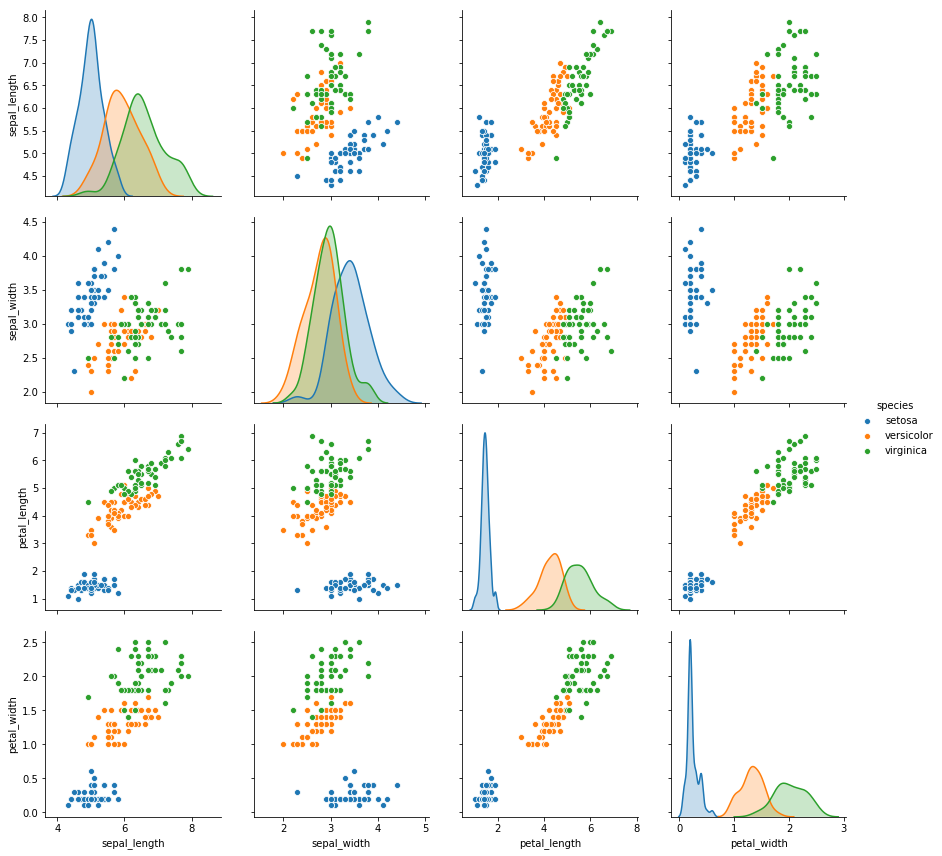

In [4]:
# also fyi, visualize the 4 parameters
sns.pairplot(iris, hue='species', height=3.0);

In [5]:
# just get the letal length and width, we reload the data from sklearn, which already has the labels
# converted to integers
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

In [6]:
# create a Decision Tree classifier and fit it to the data
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We can visualize the trained Decision Tree by first using the export_graphviz() method to output a graph
definition file called `iris_tree.dot`

In [7]:
from sklearn.tree import export_graphviz
export_graphviz(
   tree_clf,
   out_file = 'figures/iris_tree.dot',
   feature_names = iris.feature_names[2:],
   class_names = iris.target_names,
   rounded=True,
   filled=True)

You can convert this `.dot` file to a variety of formats such as PDF or PNG using the dot command-line tool
from the `graphviz` package.  This command line converts the `.dot` file to a `.png` image file:

The following line will not work unless you have the `graphviz` package installed and the `dot` command line
tool available.  However, the image is in your repository, so you should be able to see the one generated for you
even if you can't generate it for yourself.

In [8]:
!dot -Tpng figures/iris_tree.dot -o figures/iris_tree.png

The decision tree should looks like the following 

<img src="files/figures/iris_tree.png">

The decision tree is a binary tree.  At each node a feature is tested, and based on the test you either make a decision
to proceed to the left or right in the tree.   For example, the root decision (at the top of the tree) tests if the
petal length is less than 2.45 (cm).  If this is true, we proceed to the left.  All of the colored nodes in the
figure represent leaf nodes, and when you reach a leaf node then a decision is made.  If you proceed to the left,
the decision tree will classifiy the input as being in the `setosa` class.  

If however the petal length is greater than 2.45, you would instead move to the right.  Here we have not yet reached
a leaf node, so instead a second decision is made, in this case by testing the petal width.  Based on that decision,
you would proceed either left or right to the leaf nodes representing decisions for `versicolor` and `virginica`
classes respectively.  

**Note**: One nice quality about the way a decision tree works is that they require very little data preparation.
In particular, they do not require feature scaling or centering at all.

In the figure, the nodes sample attribute counts how many training instances it applies to. For example, 50 training
samples have a petal length <= 2.45 cm, and 100 samples have a petal length > 2.45.  Also the value attribute
shown in the figure gives some valuable information.  For example, for the green `versicolor` leaf node, the 
`value = [0, 49, 5]` attribute means that this leaf node applies to 54 training samples, of which it 
classifies 49 of the training samples correctly as `versicolor` and 5 of the training samples incorrectly
as `virginica`.

Finally a nodes `gini` attribute measures the nodes *impurity*: a node is "pure" (gini = 0) if all training instances
it applies to belong to the same class.  For example, since the gold leaf node only applies to `setosa` training
instances, it is pure and its gini score is 0.

The Gini impurity equation is defined using this equaiton:

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$

Where $p_{i,k}$ is the ratio of class k instances among the training instances in the $i^{th}$ node.  So for example,
the green node that categorizes as `versicolor` as a Gini coefficient of

$$
G_i = 1 - \Big( \frac{0}{54} \Big)^2 - \Big( \frac{49}{54} \Big)^2 - \Big( \frac{5}{54} \Big)^2 \approx 0.168
$$

We will later come back to the Gini impurity measure, but we present it here because it is the value that is used when
actually building/fitting the decision tree.

We had previously introduced the concept of decision boundaries for a classifier, and visualized the decision boundaries.
The decision boundaries created by our simple decision tree so far can be visualized as this:

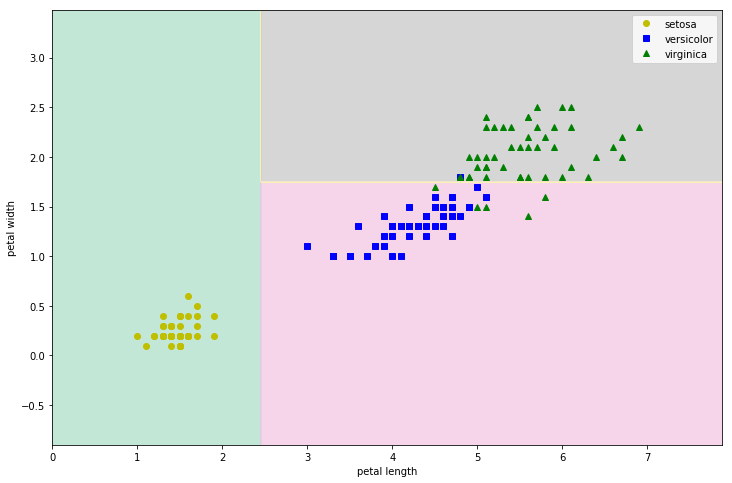

In [22]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel2, alpha=0.8);

# plot the original data
setosa_indexes = np.where(y==0)[0]
versicolor_indexes = np.where(y==1)[0]
virginica_indexes = np.where(y==2)[0]

plt.plot(X[setosa_indexes, 0], X[setosa_indexes, 1], 'yo', label='setosa')
plt.plot(X[versicolor_indexes, 0], X[versicolor_indexes, 1], 'bs', label='versicolor')
plt.plot(X[virginica_indexes, 0], X[virginica_indexes, 1], 'g^', label='virginica')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend();